# Acoustic Wave Equation in an isotropic medium with uniform density

$$\frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} + \nabla . \nabla p = s$$

In [1]:
import numpy as np
%matplotlib inline

from devito import Grid, Function, TimeFunction, SparseTimeFunction, solve, Eq, Operator
from examples.seismic import Model, plot_velocity, TimeAxis, RickerSource, Receiver, AcquisitionGeometry

# Define the domain, and the model

Note that nbl=0 because we are not damping the edges of our domain.

In [2]:
dim = 3
shape = (5, 5, 5)
extent = (5, 5, 5)
origin = (0, 0, 0)
grid = Grid(shape=shape, extent=extent, origin=origin)

so = 2 # Space order
to = 2 # Time order

# Create an initial velocity profile
v_initial = np.ones(shape)
# v_initial[:, :, 0] = 1.0

# Set up the model based on our grid and initial velocity
model = Model(origin, extent, shape, so, v_initial, nbl=0)
dt = model.critical_dt
print(dt)
print(model.__dict__)

Operator `pad_vp` ran in 0.01 s


2.5
{'shape': (5, 5, 5), 'space_order': 2, 'nbl': 0, 'origin': (0.0, 0.0, 0.0), 'fs': False, 'grid': Grid[extent=(20, 20, 20), shape=(5, 5, 5), dimensions=(x, y, z)], '_physical_parameters': {'vp'}, 'damp': 1, 'vp': vp(x, y, z), '_dt': None, '_dt_scale': 1}


In [3]:
# Set up time-scale
t0 = 0
tn = 1000
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# Now set up a source and receivers
# We will set up a source at the origin (0, 0, 0), and receivers along the line parametrized by (t, 1, 1)n
n_src = 1
n_recv = 5
src_coords = np.zeros((n_src, dim))
recv_coords = np.zeros((n_recv, dim))
for i in range(n_recv):
    recv_coords[i] = (model.grid.extent[0] * i / (n_recv - 1), model.grid.extent[-2], model.grid.extent[-1])
# print(recv_coords)
    
f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[:, :] = [model.grid.extent[i] / 2 for i in range(dim)]
print(src.coordinates.data)

rec = Receiver(name='rec', grid=model.grid, npoint=5, time_range=time_range)
rec.coordinates.data[:, :] = recv_coords
# print(type(rec.data))

m = Function(name='m', grid=model.grid, space_order=so)
u = TimeFunction(name='u', grid=model.grid, space_order=so, time_order=to)

pde = model.m * u.dt2 - u.laplace
# pde
# print(rec.data)

[[10. 10. 10.]]


In [4]:
# For some reason, they create an AcquisitionGeometry object here. Not 100% sure what it does
geometry = AcquisitionGeometry(model, rec.coordinates.data, src.coordinates.data, t0, tn, f0=f0, src_type='Ricker')

In [5]:
stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y, z), dt**2*(-(-2.0*u(t, x, y, z)/dt**2 + u(t - dt, x, y, z)/dt**2)/vp(x, y, z)**2 + Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2)))*vp(x, y, z)**2)

In [6]:
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)

In [7]:
op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)

In [8]:
print(op.ccode)
# Extract the C-Code from this

#define _POSIX_C_SOURCE 200809L
#define MIN(a,b) (((a) < (b)) ? (a) : (b))
#define MAX(a,b) (((a) > (b)) ? (a) : (b))
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(const float dt, const float o_x, const float o_y, const float o_z, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, struct dataobj *restrict u_vec, struct dataobj *restrict vp_vec

In [9]:
op(time=time_range.num-1, dt=model.critical_dt)
# print(time_range.num)
# print(model.critical_dt)
# print(model.__dict__)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0004180000000000037, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=2.900000000000001e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=8.699999999999986e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [10]:
print(rec.data.shape)

(401, 5)


In [11]:
print(rec.data)

[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 ...
 [-0.00544186 -0.00955414 -0.01127183 -0.00955413 -0.00544189]
 [-0.00339829 -0.00643984 -0.00718908 -0.00643988 -0.00339837]
 [-0.00108726 -0.00180267 -0.00201614 -0.00180274 -0.00108727]]


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

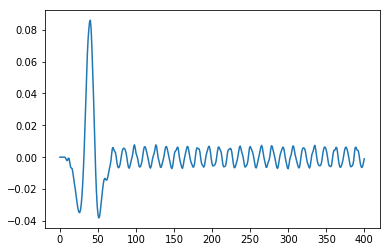

In [13]:
plt.plot(rec.data[:, 0])

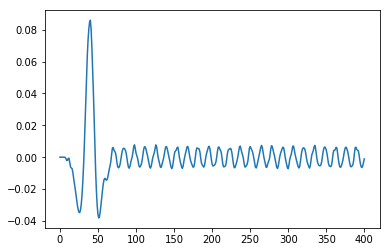

In [14]:
plt.plot(rec.data[:, 4])

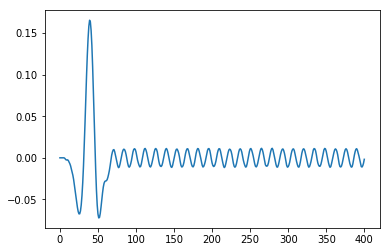

In [15]:
plt.plot(rec.data[:, 1])